In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np


def converter_gtfs_tempo(tempo_str):
    return pd.to_timedelta(tempo_str, errors='coerce')

caminho_arquivo = r"/content/drive/MyDrive/Colab/Datasets/dataset_final_unificado.csv"

df = pd.read_csv(caminho_arquivo)
print(f"Registros totais antes do processamento: {len(df)}")
print("Colunas disponíveis:", df.columns.tolist())


df['arrival_time_td'] = converter_gtfs_tempo(df['arrival_time'].astype(str))
df['departure_time_td'] = converter_gtfs_tempo(df['departure_time'].astype(str))

df.dropna(subset=['arrival_time_td', 'departure_time_td'], inplace=True)
print(f"Registros após remoção de NaT nos horários: {len(df)}")


df.sort_values(by=['trip_id', 'stop_sequence'], inplace=True)


df['prev_departure_time_td'] = df.groupby('trip_id')['departure_time_td'].shift(1)

df['duracao_segmento_seg'] = (df['arrival_time_td'] - df['prev_departure_time_td']).dt.total_seconds()


df_segmentos_validos = df[df['duracao_segmento_seg'] > 0].copy()

print(f"Registros de segmentos com duração válida (positiva): {len(df_segmentos_validos)}")

Registros totais antes do processamento: 4882082
Colunas disponíveis: ['route_id', 'service_id', 'trip_id', 'trip_headsign', 'direction_id', 'shape_id', 'agency_id', 'route_short_name', 'route_long_name', 'route_type', 'route_color', 'route_text_color', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence', 'stop_name', 'stop_desc', 'stop_lat', 'stop_lon', 'fonte_pasta']
Registros após remoção de NaT nos horários: 4882082
Registros de segmentos com duração válida (positiva): 208794


Script Completo com Otimização Refinada e Padronização (para KNN)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import time

def converter_gtfs_tempo(tempo_str):
    """Converte string de tempo GTFS (ex: '25:30:00') para Timedelta."""
    return pd.to_timedelta(tempo_str, errors='coerce')

caminho_arquivo = r"/content/drive/MyDrive/Colab/Datasets/dataset_final_unificado.csv"
df = pd.read_csv(caminho_arquivo)

print(f"Registros totais carregados: {len(df)}")

df['arrival_time_td'] = converter_gtfs_tempo(df['arrival_time'].astype(str))
df['departure_time_td'] = converter_gtfs_tempo(df['departure_time'].astype(str))

df.dropna(subset=['arrival_time_td', 'departure_time_td'], inplace=True)
df.sort_values(by=['trip_id', 'stop_sequence'], inplace=True)

df['prev_departure_time_td'] = df.groupby('trip_id')['departure_time_td'].shift(1)
df['duracao_segmento_seg'] = (df['arrival_time_td'] - df['prev_departure_time_td']).dt.total_seconds()

df_model = df[df['duracao_segmento_seg'] > 0].copy()
df_model.dropna(subset=['duracao_segmento_seg'], inplace=True)

print(f"Registros válidos para modelagem após pré-processamento: {len(df_model)}")

base_date = pd.to_datetime('2000-01-01')
df_model['departure_timestamp'] = base_date + df_model['departure_time_td']

df_model['hour_of_day'] = df_model['departure_timestamp'].dt.hour
df_model['day_of_week'] = df_model['departure_timestamp'].dt.dayofweek

features = [
    'direction_id',
    'stop_sequence',
    'stop_lat',
    'stop_lon',
    'hour_of_day',
    'day_of_week'
]

if df_model['route_id'].dtype == 'object':
    df_model['route_id_encoded'] = df_model['route_id'].astype('category').cat.codes
    features.append('route_id_encoded')
else:
    features.append('route_id')

target = 'duracao_segmento_seg'

X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamanho do conjunto de treino: {len(X_train)} amostras")
print(f"Tamanho do conjunto de teste: {len(X_test)} amostras")


scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


results = {}


print("\n--- Otimizando DecisionTreeRegressor ---")
dt_params = {
    'max_depth': [10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}
dt_grid = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
start_time = time.time()
dt_grid.fit(X_train, y_train)
end_time = time.time()
results['Decision Tree Otimizada'] = {
    'best_params': dt_grid.best_params_,
    'train_time': end_time - start_time,
    'rmse': np.sqrt(abs(dt_grid.best_score_)),
    'r2': dt_grid.cv_results_['mean_test_score'][dt_grid.best_index_]
}

y_pred_best_dt = dt_grid.best_estimator_.predict(X_test)
results['Decision Tree Otimizada']['test_rmse'] = np.sqrt(mean_squared_error(y_test, y_pred_best_dt))
results['Decision Tree Otimizada']['test_r2'] = r2_score(y_test, y_pred_best_dt)

print(f"Melhores parâmetros para Decision Tree: {dt_grid.best_params_}")
print(f"Decision Tree Otimizada - RMSE (Teste): {results['Decision Tree Otimizada']['test_rmse']:.2f} segundos")
print(f"Decision Tree Otimizada - R² (Teste): {results['Decision Tree Otimizada']['test_r2']:.2f}")


print("\n--- Otimizando RandomForestRegressor ---")


rf_params = {
    'n_estimators': [75, 100, 125],
    'max_depth': [15, 20, 25],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
start_time = time.time()
rf_grid.fit(X_train, y_train)
end_time = time.time()
results['Random Forest Otimizada'] = {
    'best_params': rf_grid.best_params_,
    'train_time': end_time - start_time,
    'rmse': np.sqrt(abs(rf_grid.best_score_)),
    'r2': rf_grid.cv_results_['mean_test_score'][rf_grid.best_index_]
}

y_pred_best_rf = rf_grid.best_estimator_.predict(X_test)
results['Random Forest Otimizada']['test_rmse'] = np.sqrt(mean_squared_error(y_test, y_pred_best_rf))
results['Random Forest Otimizada']['test_r2'] = r2_score(y_test, y_pred_best_rf)

print(f"Melhores parâmetros para Random Forest: {rf_grid.best_params_}")
print(f"Random Forest Otimizada - RMSE (Teste): {results['Random Forest Otimizada']['test_rmse']:.2f} segundos")
print(f"Random Forest Otimizada - R² (Teste): {results['Random Forest Otimizada']['test_r2']:.2f}")

print("\n--- Otimizando KNeighborsRegressor (com dados escalados) ---")
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance']
}
knn_grid = GridSearchCV(KNeighborsRegressor(n_jobs=-1), knn_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
start_time = time.time()
knn_grid.fit(X_train_scaled, y_train)
end_time = time.time()
results['KNN Otimizado'] = {
    'best_params': knn_grid.best_params_,
    'train_time': end_time - start_time,
    'rmse': np.sqrt(abs(knn_grid.best_score_)),
    'r2': knn_grid.cv_results_['mean_test_score'][knn_grid.best_index_]
}

y_pred_best_knn = knn_grid.best_estimator_.predict(X_test_scaled) # USAR X_TEST_SCALED AQUI!
results['KNN Otimizado']['test_rmse'] = np.sqrt(mean_squared_error(y_test, y_pred_best_knn))
results['KNN Otimizado']['test_r2'] = r2_score(y_test, y_pred_best_knn)

print(f"Melhores parâmetros para KNN: {knn_grid.best_params_}")
print(f"KNN Otimizado - RMSE (Teste): {results['KNN Otimizado']['test_rmse']:.2f} segundos")
print(f"KNN Otimizado - R² (Teste): {results['KNN Otimizado']['test_r2']:.2f}")

print("\n--- Resumo Final dos Modelos Otimizados ---")
for model_name, metrics in results.items():
    print(f"\nModelo: {model_name}")
    print(f"  Melhores Parâmetros: {metrics['best_params']}")
    print(f"  Tempo de Otimização: {metrics['train_time']:.2f} segundos")
    print(f"  RMSE (Teste): {metrics['test_rmse']:.2f} segundos")
    print(f"  R² (Teste): {metrics['test_r2']:.2f}")

Registros totais carregados: 4882082
Registros válidos para modelagem após pré-processamento: 208794
Tamanho do conjunto de treino: 167035 amostras
Tamanho do conjunto de teste: 41759 amostras

--- Otimizando DecisionTreeRegressor ---
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Melhores parâmetros para Decision Tree: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 20}
Decision Tree Otimizada - RMSE (Teste): 1047.57 segundos
Decision Tree Otimizada - R² (Teste): 0.94

--- Otimizando RandomForestRegressor ---
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Melhores parâmetros para Random Forest: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 125}
Random Forest Otimizada - RMSE (Teste): 1038.83 segundos
Random Forest Otimizada - R² (Teste): 0.94

--- Otimizando KNeighborsRegressor (com dados escalados) ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Melhores parâmetros para KNN: {'n_neighbors

Script para Simular Frotas Autônomas
Vamos usar o best_rf_model ja otimizado.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import time

def converter_gtfs_tempo(tempo_str):
    return pd.to_timedelta(tempo_str, errors='coerce')

# Dataset path
caminho_arquivo = r"/content/drive/MyDrive/Colab/Datasets/dataset_final_unificado.csv"
df = pd.read_csv(caminho_arquivo)

# Conversion and preprocessing
df['arrival_time_td'] = converter_gtfs_tempo(df['arrival_time'].astype(str))
df['departure_time_td'] = converter_gtfs_tempo(df['departure_time'].astype(str))
df.dropna(subset=['arrival_time_td', 'departure_time_td'], inplace=True)
df.sort_values(by=['trip_id', 'stop_sequence'], inplace=True)
df['prev_departure_time_td'] = df.groupby('trip_id')['departure_time_td'].shift(1)
df['duracao_segmento_seg'] = (df['arrival_time_td'] - df['prev_departure_time_td']).dt.total_seconds()
df_model = df[df['duracao_segmento_seg'] > 0].copy()
df_model.dropna(subset=['duracao_segmento_seg'], inplace=True)

# Creating time-related variables
base_date = pd.to_datetime('2000-01-01')
df_model['departure_timestamp'] = base_date + df_model['departure_time_td']
df_model['hour_of_day'] = df_model['departure_timestamp'].dt.hour
df_model['day_of_week'] = df_model['departure_timestamp'].dt.dayofweek

# Feature selection
features = [
    'direction_id',
    'stop_sequence',
    'stop_lat',
    'stop_lon',
    'hour_of_day',
    'day_of_week'
]
if df_model['route_id'].dtype == 'object':
    df_model['route_id_encoded'] = df_model['route_id'].astype('category').cat.codes
    features.append('route_id_encoded')
else:
    features.append('route_id')

target = 'duracao_segmento_seg'
X = df_model[features]
y = df_model[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the model
print("Retraining the best Random Forest model with the optimal parameters...")

best_rf_model = RandomForestRegressor(
    n_estimators=125,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

start_time_rf_train = time.time()
best_rf_model.fit(X_train, y_train)
end_time_rf_train = time.time()
print(f"Random Forest retraining time: {end_time_rf_train - start_time_rf_train:.2f} seconds")

# Predictions
y_pred_current = best_rf_model.predict(X_test)

# Metrics - Current scenario
mse_current = mean_squared_error(y_test, y_pred_current)
rmse_current = np.sqrt(mse_current)
r2_current = r2_score(y_test, y_pred_current)

print(f"\n--- Current Scenario Performance (Optimized Random Forest) ---")
print(f"RMSE (Current Scenario): {rmse_current:.2f} seconds ({rmse_current / 60:.2f} minutes)")
print(f"R² (Current Scenario): {r2_current:.2f}")

# ---------------------
# Scenario simulations
# ---------------------
print("\n--- Autonomous Fleet Scenario Simulation ---")

# Optimization parameters
optimization_factor = 0.15          # general reduction
severe_optimization_factor = 0.30   # reduction for slow segments

# Scenario 1 - General optimization
y_pred_autonomous_optimized = y_pred_current * (1 - optimization_factor)
y_pred_autonomous_optimized[y_pred_autonomous_optimized < 0] = 0

rmse_autonomous_optimized = np.sqrt(mean_squared_error(y_test, y_pred_autonomous_optimized))
r2_autonomous_optimized = r2_score(y_test, y_pred_autonomous_optimized)

print(f"\nScenario 1: Optimized Autonomous Fleet ({optimization_factor*100:.0f}% reduction)")
print(f"  RMSE: {rmse_autonomous_optimized:.2f} seconds ({rmse_autonomous_optimized / 60:.2f} minutes)")
print(f"  R²: {r2_autonomous_optimized:.2f}")
print(f"  Average improvement in time: {rmse_current - rmse_autonomous_optimized:.2f} seconds per segment")

# Scenario 2 - Optimization for slow segments only
slow_segment_threshold = np.percentile(y_test, 75)
print(f"\nThreshold for 'slow segments' (75th percentile): {slow_segment_threshold:.2f} seconds")

y_pred_autonomous_interdiction = np.copy(y_pred_current)
mask_slow_predicted_segments = y_pred_current > np.percentile(y_pred_current, 75)
y_pred_autonomous_interdiction[mask_slow_predicted_segments] *= (1 - severe_optimization_factor)
y_pred_autonomous_interdiction[y_pred_autonomous_interdiction < 0] = 0

rmse_autonomous_interdiction = np.sqrt(mean_squared_error(y_test, y_pred_autonomous_interdiction))
r2_autonomous_interdiction = r2_score(y_test, y_pred_autonomous_interdiction)

print(f"\nScenario 2: Autonomous Fleet Overcoming Slow Segments ({severe_optimization_factor*100:.0f}% reduction for slow segments)")
print(f"  RMSE: {rmse_autonomous_interdiction:.2f} seconds ({rmse_autonomous_interdiction / 60:.2f} minutes)")
print(f"  R²: {r2_autonomous_interdiction:.2f}")
print(f"  Average improvement in time: {rmse_current - rmse_autonomous_interdiction:.2f} seconds per segment")

# Prediction examples
print("\n--- Example Predictions (Current vs. Autonomous Scenarios) ---")
example_df = pd.DataFrame({
    'Actual_Duration': y_test.head(10).values,
    'Predicted_Current': y_pred_current[:10],
    'Predicted_Autonomous_Optimized': y_pred_autonomous_optimized[:10],
    'Predicted_Autonomous_Interdiction': y_pred_autonomous_interdiction[:10]
})
print(example_df)


Retraining the best Random Forest model with the optimal parameters...
Random Forest retraining time: 78.96 seconds

--- Current Scenario Performance (Optimized Random Forest) ---
RMSE (Current Scenario): 1038.83 seconds (17.31 minutes)
R² (Current Scenario): 0.94

--- Autonomous Fleet Scenario Simulation ---

Scenario 1: Optimized Autonomous Fleet (15% reduction)
  RMSE: 1175.28 seconds (19.59 minutes)
  R²: 0.93
  Average improvement in time: -136.45 seconds per segment

Threshold for 'slow segments' (75th percentile): 120.00 seconds

Scenario 2: Autonomous Fleet Overcoming Slow Segments (30% reduction for slow segments)
  RMSE: 1599.49 seconds (26.66 minutes)
  R²: 0.86
  Average improvement in time: -560.66 seconds per segment

--- Example Predictions (Current vs. Autonomous Scenarios) ---
   Actual_Duration  Predicted_Current  Predicted_Autonomous_Optimized  \
0            200.0         101.933992                       86.643893   
1             38.0          51.290322            

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import time

def converter_gtfs_tempo(tempo_str):
    return pd.to_timedelta(tempo_str, errors='coerce')

# Dataset path
file_path = r"/content/drive/MyDrive/Colab/Datasets/dataset_final_unificado.csv"
df = pd.read_csv(file_path)

# Time conversion and preprocessing
df['arrival_time_td'] = converter_gtfs_tempo(df['arrival_time'].astype(str))
df['departure_time_td'] = converter_gtfs_tempo(df['departure_time'].astype(str))
df.dropna(subset=['arrival_time_td', 'departure_time_td'], inplace=True)
df.sort_values(by=['trip_id', 'stop_sequence'], inplace=True)
df['prev_departure_time_td'] = df.groupby('trip_id')['departure_time_td'].shift(1)
df['duracao_segmento_seg'] = (df['arrival_time_td'] - df['prev_departure_time_td']).dt.total_seconds()
df_model = df[df['duracao_segmento_seg'] > 0].copy()
df_model.dropna(subset=['duracao_segmento_seg'], inplace=True)

# Create time-based features
base_date = pd.to_datetime('2000-01-01')
df_model['departure_timestamp'] = base_date + df_model['departure_time_td']
df_model['hour_of_day'] = df_model['departure_timestamp'].dt.hour
df_model['day_of_week'] = df_model['departure_timestamp'].dt.dayofweek

# Feature list
features = [
    'direction_id',
    'stop_sequence',
    'stop_lat',
    'stop_lon',
    'hour_of_day',
    'day_of_week'
]
if df_model['route_id'].dtype == 'object':
    df_model['route_id_encoded'] = df_model['route_id'].astype('category').cat.codes
    features.append('route_id_encoded')
else:
    features.append('route_id')

target = 'duracao_segmento_seg'
X = df_model[features]
y = df_model[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Retraining the best Random Forest model with the optimal parameters...")

# Random Forest model
best_rf_model = RandomForestRegressor(
    n_estimators=125,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

start_time_rf_train = time.time()
best_rf_model.fit(X_train, y_train)
end_time_rf_train = time.time()
print(f"Random Forest retraining time: {end_time_rf_train - start_time_rf_train:.2f} seconds")

# Predictions for current scenario
y_pred_current = best_rf_model.predict(X_test)

# Performance metrics for current scenario
mse_current = mean_squared_error(y_test, y_pred_current)
rmse_current = np.sqrt(mse_current)
r2_current = r2_score(y_test, y_pred_current)

print(f"\n--- Current Model Performance (Optimized Random Forest) ---")
print(f"RMSE (Current Scenario): {rmse_current:.2f} seconds ({rmse_current / 60:.2f} minutes)")
print(f"R² (Current Scenario): {r2_current:.2f}")

print("\n--- Autonomous Fleet Scenario Simulation ---")

# Optimization factors
optimization_factor = 0.15

# Scenario 1 - General optimization
y_pred_autonomous_optimized = y_pred_current * (1 - optimization_factor)
y_pred_autonomous_optimized[y_pred_autonomous_optimized < 0] = 0

print(f"\nScenario 1: Optimized Autonomous Fleet ({optimization_factor*100:.0f}% reduction over current predicted times)")

economy_seconds_optimized = y_pred_current - y_pred_autonomous_optimized
avg_economy_optimized = np.mean(economy_seconds_optimized)

print(f"  Average time savings per segment: {avg_economy_optimized:.2f} seconds ({avg_economy_optimized / 60:.2f} minutes)")
print(f"  Average segment time (Current Scenario): {np.mean(y_pred_current):.2f} seconds")
print(f"  Average segment time (Optimized Autonomous Scenario): {np.mean(y_pred_autonomous_optimized):.2f} seconds")

# Scenario 2 - Severe optimization for slow segments
severe_optimization_factor = 0.30
y_pred_autonomous_interdiction = np.copy(y_pred_current)

mask_slow_predicted_segments = y_pred_current > np.percentile(y_pred_current, 75)
y_pred_autonomous_interdiction[mask_slow_predicted_segments] *= (1 - severe_optimization_factor)

# For non-slow segments, apply the general optimization factor
y_pred_autonomous_interdiction[~mask_slow_predicted_segments] *= (1 - optimization_factor)

y_pred_autonomous_interdiction[y_pred_autonomous_interdiction < 0] = 0

print(f"\nScenario 2: Autonomous Fleet Overcoming Slow Segments ({severe_optimization_factor*100:.0f}% reduction in slow segments + {optimization_factor*100:.0f}% in others)")
economy_seconds_interdiction = y_pred_current - y_pred_autonomous_interdiction
avg_economy_interdiction = np.mean(economy_seconds_interdiction)

print(f"  Average time savings per segment: {avg_economy_interdiction:.2f} seconds ({avg_economy_interdiction / 60:.2f} minutes)")
print(f"  Average segment time (Current Scenario): {np.mean(y_pred_current):.2f} seconds")
print(f"  Average segment time (Autonomous Interdiction Scenario): {np.mean(y_pred_autonomous_interdiction):.2f} seconds")

# Example predictions
print("\n--- Example Predictions (Current vs. Autonomous Scenarios) ---")
example_df = pd.DataFrame({
    'Actual_Duration': y_test.head(10).values,
    'Predicted_Current': y_pred_current[:10],
    'Predicted_Autonomous_Optimized': y_pred_autonomous_optimized[:10],
    'Predicted_Autonomous_Interdiction': y_pred_autonomous_interdiction[:10]
})
print(example_df)


Retraining the best Random Forest model with the optimal parameters...
Random Forest retraining time: 82.21 seconds

--- Current Model Performance (Optimized Random Forest) ---
RMSE (Current Scenario): 1038.83 seconds (17.31 minutes)
R² (Current Scenario): 0.94

--- Autonomous Fleet Scenario Simulation ---

Scenario 1: Optimized Autonomous Fleet (15% reduction over current predicted times)
  Average time savings per segment: 128.33 seconds (2.14 minutes)
  Average segment time (Current Scenario): 855.52 seconds
  Average segment time (Optimized Autonomous Scenario): 727.20 seconds

Scenario 2: Autonomous Fleet Overcoming Slow Segments (30% reduction in slow segments + 15% in others)
  Average time savings per segment: 248.58 seconds (4.14 minutes)
  Average segment time (Current Scenario): 855.52 seconds
  Average segment time (Autonomous Interdiction Scenario): 606.95 seconds

--- Example Predictions (Current vs. Autonomous Scenarios) ---
   Actual_Duration  Predicted_Current  Predict

/tmp/ipython-input-3007344713.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


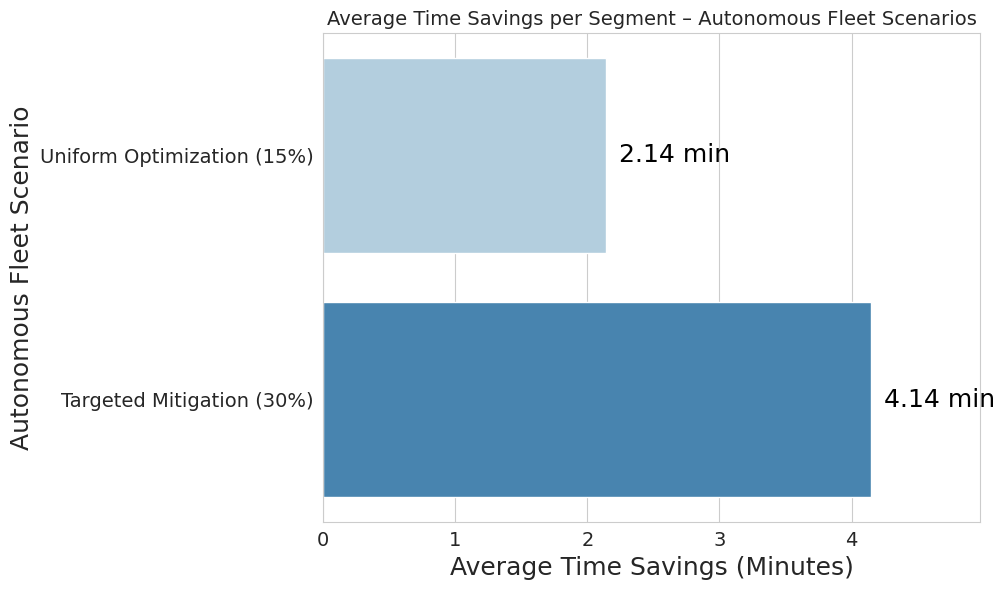

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

avg_economy_optimized = np.mean((y_pred_current - y_pred_autonomous_optimized) / 60)
avg_economy_interdiction = np.mean((y_pred_current - y_pred_autonomous_interdiction) / 60)

df_economy = pd.DataFrame({
    'Scenario': ['Uniform Optimization (15%)', 'Targeted Mitigation (30%)'],
    'Average Time Savings (Minutes)': [avg_economy_optimized, avg_economy_interdiction]
})

sns.set_style("whitegrid")
font_sizes = {
    'title': 14,
    'labels': 18,
    'ticks': 14,
    'annotation': 18
}
plt.rc('axes', titlesize=font_sizes['title'])
plt.rc('axes', labelsize=font_sizes['labels'])
plt.rc('xtick', labelsize=font_sizes['ticks'])
plt.rc('ytick', labelsize=font_sizes['ticks'])

plt.figure(figsize=(10, 6))

ax = sns.barplot(
    x='Average Time Savings (Minutes)',
    y='Scenario',
    data=df_economy,
    palette='Blues'
)

plt.title('Average Time Savings per Segment – Autonomous Fleet Scenarios')
plt.xlabel('Average Time Savings (Minutes)')
plt.ylabel('Autonomous Fleet Scenario')
plt.xlim(0, df_economy['Average Time Savings (Minutes)'].max() * 1.2)

for index, row in df_economy.iterrows():
    ax.text(row['Average Time Savings (Minutes)'] + 0.1, index,
            f"{row['Average Time Savings (Minutes)']:.2f} min",
            color='black', va="center", fontsize=font_sizes['annotation'])

plt.tight_layout()
plt.savefig("Average_Time_per_Segment.eps", format='eps', dpi=300)
plt.show()

/tmp/ipython-input-1259582109.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


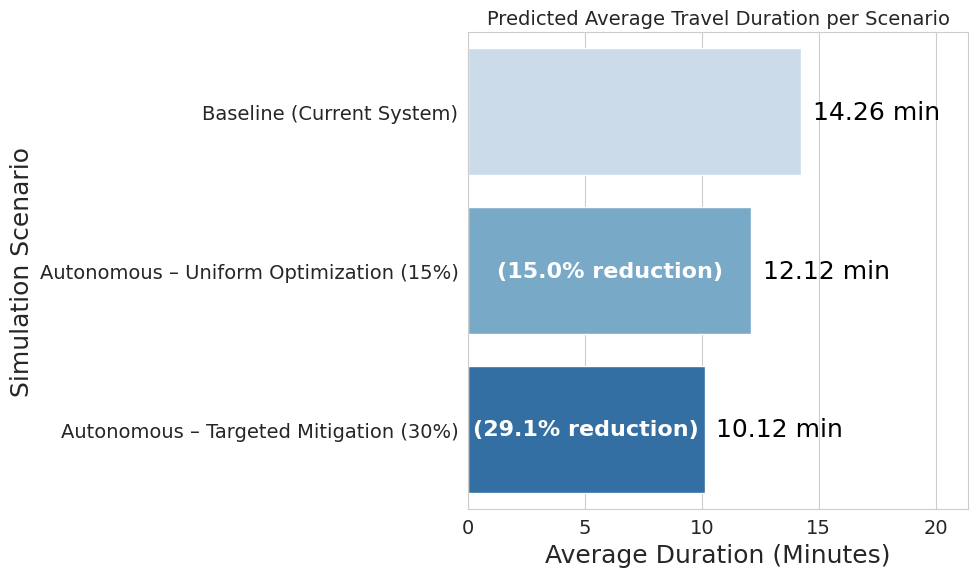

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

mean_current_duration = np.mean(y_pred_current) / 60
mean_optimized_duration = np.mean(y_pred_autonomous_optimized) / 60
mean_interdiction_duration = np.mean(y_pred_autonomous_interdiction) / 60

df_mean_durations = pd.DataFrame({
    'Scenario': [
        'Baseline (Current System)',
        'Autonomous – Uniform Optimization (15%)',
        'Autonomous – Targeted Mitigation (30%)'
    ],
    'Average Duration (Minutes)': [
        mean_current_duration,
        mean_optimized_duration,
        mean_interdiction_duration
    ]
})

font_sizes = {
    'title': 14,
    'labels': 18,
    'ticks': 14,
    'legend': 18,
    'annotation': 18,
    'percentage': 16
}
sns.set_style("whitegrid")
plt.rc('axes', titlesize=font_sizes['title'])
plt.rc('axes', labelsize=font_sizes['labels'])
plt.rc('xtick', labelsize=font_sizes['ticks'])
plt.rc('ytick', labelsize=font_sizes['ticks'])
plt.rc('legend', fontsize=font_sizes['legend'])
plt.rc('font', size=font_sizes['ticks'])

plt.figure(figsize=(10, 6))

ax = sns.barplot(
    x='Average Duration (Minutes)',
    y='Scenario',
    data=df_mean_durations,
    palette='Blues'
)

plt.title('Predicted Average Travel Duration per Scenario')
plt.xlabel('Average Duration (Minutes)')
plt.ylabel('Simulation Scenario')

plt.xlim(0, df_mean_durations['Average Duration (Minutes)'].max() * 1.5)

for index, row in df_mean_durations.iterrows():

    ax.text(row['Average Duration (Minutes)'] + 0.5, index,
            f"{row['Average Duration (Minutes)']:.2f} min",
            color='black', va="center", fontsize=font_sizes['annotation'])


    if index > 0:
        reduction_percent = ((mean_current_duration - row['Average Duration (Minutes)']) / mean_current_duration) * 100

        ax.text(row['Average Duration (Minutes)'] / 2, index,
                f"({reduction_percent:.1f}% reduction)",
                color='white', va="center", ha='center', fontsize=font_sizes['percentage'], weight='bold')

plt.tight_layout()
plt.savefig("horizontal_duration_per_Scenario.eps", format='eps', dpi=300)
plt.show()